##### Example Temporal BEND Analysis
##### Jonathan H. Morgan, Ph.D.
##### 31 May 2024

In [42]:
#Importing Packages
import os
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

#Setting Working Directory
os.chdir("/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis")

#Checking the directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

print(pm.__version__)

Current Working Directory: /mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis
5.15.1


In [43]:
#Import Function
def convert_to_bigint(val):
    return int(val)

def bend_stance_aggregation(data_directory, report_directory, data_name):
    # Pull-In BEND Report Data
    bend_files = os.listdir(report_directory)
    targeting_file = [f for f in bend_files if "agent-bend-documents-authored.csv" in f][0]
    targets_file = [f for f in bend_files if "agent-bend-documents-targeted-by.csv" in f][0]

    targeting_data = pd.read_csv(os.path.join(report_directory, targeting_file))
    targeting_data.iloc[:, 0] = targeting_data.iloc[:, 0].apply(convert_to_bigint)

    targets_data = pd.read_csv(os.path.join(report_directory, targets_file))
    targets_data.iloc[:, 0] = targets_data.iloc[:, 0].apply(convert_to_bigint)

    # Making ID Names Canonical
    targeting_data.rename(columns={targeting_data.columns[0]: 'AgentID'}, inplace=True)
    targets_data.rename(columns={targets_data.columns[0]: 'AgentID'}, inplace=True)

    # Isolating Counts & Accounts
    var_names = targets_data.columns
    filtered_columns = [col for col in var_names if "count" in col.lower()]
    filtered_columns = ['AgentID'] + filtered_columns

    if sum('count' in col for col in targets_data.columns) > 0:
        targets_data = targets_data[filtered_columns]
    if sum('count' in col for col in targeting_data.columns) > 0:
        targeting_data = targeting_data[filtered_columns]

    # Pulling-In Stance Data
    stance_files = os.listdir(data_directory)
    stance_file = [f for f in stance_files if "user" in f][0]

    stance_data = pd.read_csv(os.path.join(data_directory, stance_file))
    stance_data.iloc[:, 0] = stance_data.iloc[:, 0].apply(convert_to_bigint)

    # Eliminating Low Confidence Observations
    stance_data.rename(columns={"Node ID": "AgentID"}, inplace=True)
    targeting_data = targeting_data.merge(stance_data, on='AgentID', how='left')
    targets_data = targets_data.merge(stance_data, on='AgentID', how='left')

    targeting_data['stance'] = targeting_data['stance'].astype(int)
    targets_data['stance'] = targets_data['stance'].astype(int)
    targeting_data['stance-confidence'] = targeting_data['stance-confidence'].astype(float)
    targets_data['stance-confidence'] = targets_data['stance-confidence'].astype(float)

    targeting_data = targeting_data[targeting_data['stance-confidence'] >= 0.5]
    targets_data = targets_data[targets_data['stance-confidence'] >= 0.5]

    # Calculating Stance Counts per Maneuver
    targeting_group_sums = targeting_data.groupby('stance').sum().reset_index()
    targeting_group_sums.insert(0, 'data', data_name)

    targets_group_sums = targets_data.groupby('stance').sum().reset_index()
    targets_group_sums.insert(0, 'data', data_name)

    # Return Data
    return targeting_group_sums, targets_group_sums

In [44]:
#Design Matrix Function
def transform_to_design_matrix(df, category_column, time_column, maneuvers):
    # Calculate the total number of rows needed
    num_rows = len(maneuvers) * len(df[category_column].unique()) * len(df[time_column].unique())
    
    # Initialize an empty DataFrame for the design matrix
    columns = ['outcome', category_column, time_column] + maneuvers
    design_df = pd.DataFrame(np.zeros((num_rows, len(columns))), columns=columns)
    
    # Populate the DataFrame
    row_index = 0
    for _, row in df.iterrows():
        for maneuver in maneuvers:
            # Set the outcome to the maneuver value
            design_df.at[row_index, 'outcome'] = row[maneuver]
            
            # Set the stance value
            design_df.at[row_index, category_column] = row[category_column]
            
            # Set the week value
            design_df.at[row_index, time_column] = row[time_column]
            
            # Set the binary indicator for the maneuver
            design_df.at[row_index, maneuver] = 1.0
            
            # Update the row index
            row_index += 1
    
    # Convert binary columns to integers for cleaner output
    design_df[category_column] = design_df[category_column].astype(int)
    design_df[time_column] = design_df[time_column].astype(int)
    for maneuver in maneuvers:
        design_df[maneuver] = design_df[maneuver].astype(int)
    
    # Return the design matrix
    return design_df

### Importing Data

In [45]:
#Pulling-In Week 1
report_directory = '/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/Week_1'
data_directory = '/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/Week_1'
data_name = 'UpToApril18th'

targeting_period_1, targets_period_1 = bend_stance_aggregation(data_directory, report_directory, data_name)

#Adding Week Indicator Variable
targeting_period_1.insert(1, 'week', 1)
targets_period_1.insert(1, 'week', 1)

In [46]:
#Quickly Checking Targeting Data
targeting_period_1.head(10)


,data,week,stance,AgentID,Back-document-count,Build-document-count,Bridge-document-count,Boost-document-count,Excite-document-count,Engage-document-count,...,Enhance-document-count,Neutralize-document-count,Negate-document-count,Narrow-document-count,Neglect-document-count,Dismay-document-count,Dismiss-document-count,Distort-document-count,Distract-document-count,stance-confidence
0,UpToApril18th,1,-1,472110111553840083,0,0,185,0,691,742,...,197,0,0,740,1622,691,0,0,740,712.082842
1,UpToApril18th,1,1,5829979778763593180,0,0,1826,0,14136,14536,...,2104,0,0,10145,38149,14136,0,0,10145,7191.062287


In [47]:
#Quickly Checking Targest Data
targets_period_1.head(10)

,data,week,stance,AgentID,Back-document-count,Build-document-count,Bridge-document-count,Boost-document-count,Excite-document-count,Engage-document-count,...,Enhance-document-count,Neutralize-document-count,Negate-document-count,Narrow-document-count,Neglect-document-count,Dismay-document-count,Dismiss-document-count,Distort-document-count,Distract-document-count,stance-confidence
0,UpToApril18th,1,-1,472110111553840083,28,45,19,45,43,24,...,8,11,9,12,0,40,43,29,17,712.082842
1,UpToApril18th,1,1,5829979778763593180,1790,1900,1207,1900,1900,1176,...,1445,1772,1675,1079,0,1891,1900,1253,1615,7191.062287


In [48]:
#Pulling-In Week 2 
report_directory = '/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/Week_2'
data_directory = '/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/Week_2'
data_name = '18_29Apr'

targeting_period_2, targets_period_2 = bend_stance_aggregation(data_directory, report_directory, data_name)

#Adding Week Indicator Variable
targeting_period_2.insert(1, 'week', 2)
targets_period_2.insert(1, 'week', 2)

In [49]:
#Pulling-In Week 3 
report_directory = '/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/Week_3'
data_directory = '/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/Week_3'
data_name = '29Apr24_2May24'

targeting_period_3, targets_period_3 = bend_stance_aggregation(data_directory, report_directory, data_name)

#Adding Week Indicator Variable
targeting_period_3.insert(1, 'week', 3)
targets_period_3.insert(1, 'week', 3)

In [50]:
#Pulling-In Week 4
report_directory = '/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/Week_4'
data_directory = '/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/Week_4'
data_name = '2_9May'

targeting_period_4, targets_period_4 = bend_stance_aggregation(data_directory, report_directory, data_name)

#Adding Week Indicator Variable
targeting_period_4.insert(1, 'week', 4)
targets_period_4.insert(1, 'week', 4)

In [51]:
#Pulling-In Week 5
report_directory = '/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/Week_5'
data_directory = '/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/Week_5'
data_name = '9_16May'

targeting_period_5, targets_period_5 = bend_stance_aggregation(data_directory, report_directory, data_name)

#Adding Week Indicator Variable
targeting_period_5.insert(1, 'week', 5)
targets_period_5.insert(1, 'week', 5)

### Constructing the Targeting & Targeted Datasets

In [52]:
#Rename the columns of targeting_period_4 to match those of targeting_period_3
targeting_period_4.columns = targeting_period_3.columns

#Concatenate the DataFrames
targeting_data = pd.concat([targeting_period_1, targeting_period_2, targeting_period_3, targeting_period_4, targeting_period_5])
targets_data = pd.concat([targets_period_1, targets_period_2, targets_period_3, targets_period_4, targets_period_5])

#Display the concatenated DataFrames
print("targeting_data:")
print(targeting_data)

targeting_data:
             data  week  stance              AgentID  Back-document-count  \
0   UpToApril18th     1      -1   472110111553840083                    0   
1   UpToApril18th     1       1  5829979778763593180                    0   
0        18_29Apr     2      -1     3001754349297858                    0   
1        18_29Apr     2       1  2440297992648958698                  195   
0  29Apr24_2May24     3      -1   488089464343627659                    0   
1  29Apr24_2May24     3       1   210684116723426244                    9   
0          2_9May     4      -1   450177400174557939                   10   
1          2_9May     4       1  4722342096467730267                  345   
0         9_16May     5      -1    10445980488511071                    0   
1         9_16May     5       1  1287069361578838274                  186   

   Build-document-count  Bridge-document-count  Boost-document-count  \
0                     0                    185                  

In [53]:
#Define the new column names
reduced_names = ["data", "week", "stance", "AgentID", "Back", "Build", "Bridge", "Boost", "Excite", "Engage", "Explain", "Enhance",
                 "Neutralize", "Negate", "Narrow", "Neglect", "Dismay", "Dismiss", "Distort", "Distract", "stance-confidence"]

#Rename the columns
if len(targeting_data.columns) == len(reduced_names):
    targeting_data.columns = reduced_names
else:
    print("Number of columns in targeting_data does not match the length of reduced_names.")

if len(targets_data.columns) == len(reduced_names):
    targets_data.columns = reduced_names
else:
    print("Number of columns in targets_data does not match the length of reduced_names.")

#Print column names
print("Column names of targeting_data:")
print(targeting_data.columns.tolist())

print("\nColumn names of targets_data:")
print(targets_data.columns.tolist())

Column names of targeting_data:
['data', 'week', 'stance', 'AgentID', 'Back', 'Build', 'Bridge', 'Boost', 'Excite', 'Engage', 'Explain', 'Enhance', 'Neutralize', 'Negate', 'Narrow', 'Neglect', 'Dismay', 'Dismiss', 'Distort', 'Distract', 'stance-confidence']

Column names of targets_data:
['data', 'week', 'stance', 'AgentID', 'Back', 'Build', 'Bridge', 'Boost', 'Excite', 'Engage', 'Explain', 'Enhance', 'Neutralize', 'Negate', 'Narrow', 'Neglect', 'Dismay', 'Dismiss', 'Distort', 'Distract', 'stance-confidence']


In [54]:
#Apply the inverse hyperbolic sine transformation to the specified columns
cols_to_transform = ["Back", "Build", "Bridge", "Boost", "Excite", "Engage", "Explain", "Enhance",
                     "Neutralize", "Negate", "Narrow", "Neglect", "Dismay", "Dismiss", "Distort", "Distract"]

targeting_data[cols_to_transform] = np.arcsinh(targeting_data[cols_to_transform])
targets_data[cols_to_transform] = np.arcsinh(targets_data[cols_to_transform])

print(targeting_data)

             data  week  stance              AgentID      Back     Build  \
0   UpToApril18th     1      -1   472110111553840083  0.000000  0.000000   
1   UpToApril18th     1       1  5829979778763593180  0.000000  0.000000   
0        18_29Apr     2      -1     3001754349297858  0.000000  4.969862   
1        18_29Apr     2       1  2440297992648958698  5.966153  7.475340   
0  29Apr24_2May24     3      -1   488089464343627659  0.000000  2.893444   
1  29Apr24_2May24     3       1   210684116723426244  2.893444  6.276647   
0          2_9May     4      -1   450177400174557939  2.998223  6.923630   
1          2_9May     4       1  4722342096467730267  6.536694  9.184817   
0         9_16May     5      -1    10445980488511071  0.000000  4.025670   
1         9_16May     5       1  1287069361578838274  5.918901  7.453562   

     Bridge     Boost     Excite     Engage  ...   Enhance  Neutralize  \
0  5.913510  0.000000   7.231288   7.302497  ...  5.976357    0.000000   
1  8.203030  0.

In [55]:
#Dropping AgentID & stance-confidence as they are no longer needed
targeting_data = targeting_data.drop(columns=['stance-confidence', 'AgentID'])
targets_data = targets_data.drop(columns=['stance-confidence', 'AgentID'])

print(targets_data)

             data  week  stance      Back     Build    Bridge     Boost  \
0   UpToApril18th     1      -1  4.025670  4.499933  3.638278  4.499933   
1   UpToApril18th     1       1  8.183118  8.242756  7.789041  8.242756   
0        18_29Apr     2      -1  0.000000  0.000000  0.000000  0.000000   
1        18_29Apr     2       1  8.143808  8.211754  7.470794  8.146130   
0  29Apr24_2May24     3      -1  0.000000  0.000000  0.000000  0.000000   
1  29Apr24_2May24     3       1  4.543408  4.912709  4.605270  4.787561   
0          2_9May     4      -1  3.829114  4.025670  3.912423  3.871635   
1          2_9May     4       1  8.190909  8.257904  7.509883  8.174139   
0         9_16May     5      -1  0.000000  0.000000  0.000000  0.000000   
1         9_16May     5       1  8.165079  8.242756  7.501082  8.126223   

     Excite    Engage   Explain   Enhance  Neutralize    Negate    Narrow  \
0  4.454482  3.871635  4.406868  2.776472    3.093102  2.893444  3.179785   
1  8.242756  7.76302

In [56]:
#Transform negative stances to 2 for model specification
targeting_data['stance'] = np.where(targeting_data['stance'] == -1, 2, 1)
targets_data['stance'] = np.where(targets_data['stance'] == -1, 2, 1)

#Display the transformed DataFrames
print("Transformed targeting_data:")
print(targeting_data)

Transformed targeting_data:
             data  week  stance      Back     Build    Bridge     Boost  \
0   UpToApril18th     1       2  0.000000  0.000000  5.913510  0.000000   
1   UpToApril18th     1       1  0.000000  0.000000  8.203030  0.000000   
0        18_29Apr     2       2  0.000000  4.969862  4.927306  4.882859   
1        18_29Apr     2       1  5.966153  7.475340  7.881560  7.886833   
0  29Apr24_2May24     3       2  0.000000  2.893444  4.753664  4.625069   
1  29Apr24_2May24     3       1  2.893444  6.276647  7.445418  7.415777   
0          2_9May     4       2  2.998223  6.923630  7.463937  7.231288   
1          2_9May     4       1  6.536694  9.184817  9.557187  9.469160   
0         9_16May     5       2  0.000000  4.025670  4.025670  3.912423   
1         9_16May     5       1  5.918901  7.453562  7.657283  7.566311   

      Excite     Engage    Explain   Enhance  Neutralize    Negate     Narrow  \
0   7.231288   7.302497   7.231288  5.976357    0.000000  0.00000

In [57]:
#Get the column names from the 4th to the last column
maneuvers_targeting = targeting_data.columns[4:].tolist()
maneuvers_targets = targets_data.columns[4:].tolist()

#Construct the design matrices
targeting_design_matrix = transform_to_design_matrix(targeting_data, 'stance', 'week', maneuvers_targeting)
targets_design_matrix = transform_to_design_matrix(targets_data, 'stance', 'week', maneuvers_targets)

#Display the design matrices
print("Targeting Design Matrix:")
print(targeting_design_matrix)

print("\nTargets Design Matrix:")
print(targets_design_matrix)

Targeting Design Matrix:
      outcome  stance  week  Build  Bridge  Boost  Excite  Engage  Explain  \
0    0.000000       2     1      1       0      0       0       0        0   
1    5.913510       2     1      0       1      0       0       0        0   
2    0.000000       2     1      0       0      1       0       0        0   
3    7.231288       2     1      0       0      0       1       0        0   
4    7.302497       2     1      0       0      0       0       1        0   
..        ...     ...   ...    ...     ...    ...     ...     ...      ...   
145  8.368693       1     5      0       0      0       0       0        0   
146  7.662938       1     5      0       0      0       0       0        0   
147  7.925158       1     5      0       0      0       0       0        0   
148  7.571474       1     5      0       0      0       0       0        0   
149  7.654443       1     5      0       0      0       0       0        0   

     Enhance  Neutralize  Negate  Narr

In [58]:
#Filter the DataFrames to eliminate rows where the outcome is 0
targeting_design_matrix = targeting_design_matrix[targeting_design_matrix['outcome'] != 0]
targets_design_matrix = targets_design_matrix[targets_design_matrix['outcome'] != 0]

#Display the filtered design matrices
print("Filtered Targeting Design Matrix:")
print(targeting_design_matrix)

print("\nFiltered Targets Design Matrix:")
print(targets_design_matrix)

Filtered Targeting Design Matrix:
      outcome  stance  week  Build  Bridge  Boost  Excite  Engage  Explain  \
1    5.913510       2     1      0       1      0       0       0        0   
3    7.231288       2     1      0       0      0       1       0        0   
4    7.302497       2     1      0       0      0       0       1        0   
5    7.231288       2     1      0       0      0       0       0        1   
6    5.976357       2     1      0       0      0       0       0        0   
..        ...     ...   ...    ...     ...    ...     ...     ...      ...   
145  8.368693       1     5      0       0      0       0       0        0   
146  7.662938       1     5      0       0      0       0       0        0   
147  7.925158       1     5      0       0      0       0       0        0   
148  7.571474       1     5      0       0      0       0       0        0   
149  7.654443       1     5      0       0      0       0       0        0   

     Enhance  Neutralize  Neg

/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/temporal_bend_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


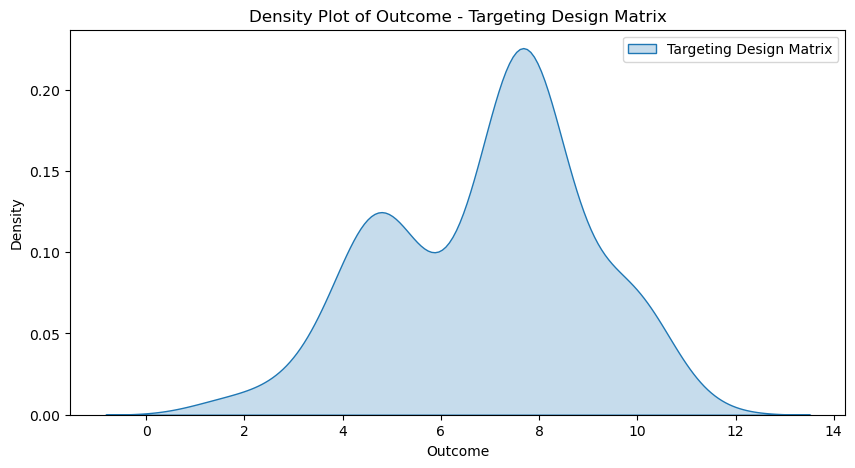

In [59]:
#Quickly Looking at the Targeting Distribution
plt.figure(figsize=(10, 5))
sns.kdeplot(targeting_design_matrix['outcome'], fill=True, label='Targeting Design Matrix')
plt.title('Density Plot of Outcome - Targeting Design Matrix')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.legend()
plt.show()

/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/temporal_bend_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


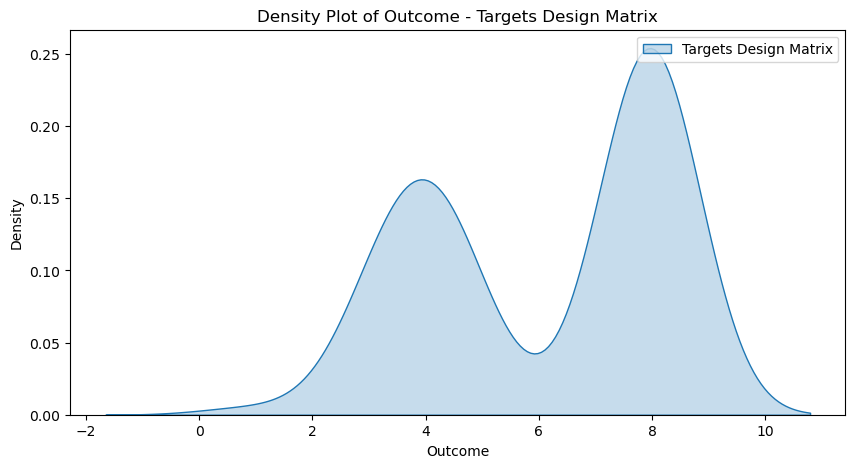

In [60]:
#Looking at the Targeted Distribution
plt.figure(figsize=(10, 5))
sns.kdeplot(targets_design_matrix['outcome'], fill=True, label='Targets Design Matrix')
plt.title('Density Plot of Outcome - Targets Design Matrix')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.legend()
plt.show()

### Constructing Targeting Model Inputs

In [61]:
# Create the Design Matrix by excluding 'outcome', 'stance', and 'week' columns
X_matrix = targeting_design_matrix.drop(columns=['outcome', 'stance', 'week']).to_numpy()

# Extract the outcome vector
outcome_vector = targeting_design_matrix['outcome'].to_numpy()

# Extract the stance group vector
stance_group_vector = targeting_design_matrix['stance'].to_numpy()

# Extract the time group vector
time_group_vector = targeting_design_matrix['week'].to_numpy()

# Prepare the data dictionary for PyMC
targeting_bend_data = {
    "N": X_matrix.shape[0],
    "K": X_matrix.shape[1], # Exclude outcome, stance, and week
    "J": len(np.unique(stance_group_vector)),
    "W": len(np.unique(time_group_vector)),
    "stance": stance_group_vector,
    "week": time_group_vector,
    "X":  X_matrix, # Exclude outcome, stance, and week columns
    "y": outcome_vector
}

# Display the prepared data dictionary
print("Prepared Data Dictionary for PyMC:")
for key, value in targeting_bend_data.items():
    print(f"{key}: {value}")

Prepared Data Dictionary for PyMC:
N: 135
K: 15
J: 2
W: 5
stance: [2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
week: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
X: [[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
y: [ 5.91351031  7.23128753  7.30249688  7.23128753  5.97635735  7.29979782
  8.08456251  7.23128753  7.29979782  8.20303032 10.2496272  10.27753079
 10.2496272   8.34474281  9.91788344 11.242402   10.2496272   9.91788344
  4.96986152  4.92730619  4.88285

### Esimating the Maneuvering/Targeting Model

In [62]:
#Define and estimate the model using PyMC
with pm.Model() as model:
    # Data
    N = targeting_bend_data['N']
    K = targeting_bend_data['K']
    J = targeting_bend_data['J']
    W = targeting_bend_data['W']
    stance = targeting_bend_data['stance']
    week = targeting_bend_data['week']
    X = targeting_bend_data['X']
    y = targeting_bend_data['y']

    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=K)
    alpha_stance = pm.Normal('alpha_stance', mu=0, sigma=1, shape=J)
    alpha_week = pm.Normal('alpha_week', mu=0, sigma=1, shape=W)
    sigma = pm.HalfCauchy('sigma', beta=2)

    # Linear predictor
    mu = alpha + pm.math.dot(X, beta) + alpha_stance[stance-1] + alpha_week[week-1]

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # Sample from the posterior using the NUTS sampler
    trace = pm.sample(2000, tune=1000, chains=4, return_inferencedata=True)
    
    # Posterior predictive checks
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["y_obs"])

#Display summary of the trace
print(pm.summary(trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, alpha_stance, alpha_week, sigma]


/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/temporal_bend_env/lib/python3.12/site-packages/r
ich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.
Sampling: [y_obs]


/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/temporal_bend_env/lib/python3.12/site-packages/r
ich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha            3.913  0.642   2.735    5.137      0.012    0.008    2864.0   
alpha_stance[0]  3.345  0.603   2.204    4.441      0.011    0.008    3055.0   
alpha_stance[1]  0.529  0.604  -0.556    1.706      0.011    0.008    3052.0   
alpha_week[0]    1.926  0.451   1.090    2.771      0.010    0.007    1894.0   
alpha_week[1]    0.088  0.441  -0.734    0.923      0.010    0.007    1793.0   
alpha_week[2]   -0.120  0.442  -0.978    0.676      0.011    0.008    1716.0   
alpha_week[3]    2.220  0.442   1.442    3.095      0.010    0.007    1797.0   
alpha_week[4]   -0.282  0.442  -1.107    0.530      0.010    0.007    1840.0   
beta[0]         -0.163  0.355  -0.806    0.516      0.007    0.005    2613.0   
beta[1]          0.156  0.337  -0.475    0.782      0.007    0.005    2370.0   
beta[2]          0.275  0.358  -0.396    0.944      0.007    0.005    2735.0   
beta[3]          0.624  0.337  -0.022   

In [63]:
# Get a summary of the trace
summary = az.summary(trace)
print(summary)

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha            3.913  0.642   2.735    5.137      0.012    0.008    2864.0   
alpha_stance[0]  3.345  0.603   2.204    4.441      0.011    0.008    3055.0   
alpha_stance[1]  0.529  0.604  -0.556    1.706      0.011    0.008    3052.0   
alpha_week[0]    1.926  0.451   1.090    2.771      0.010    0.007    1894.0   
alpha_week[1]    0.088  0.441  -0.734    0.923      0.010    0.007    1793.0   
alpha_week[2]   -0.120  0.442  -0.978    0.676      0.011    0.008    1716.0   
alpha_week[3]    2.220  0.442   1.442    3.095      0.010    0.007    1797.0   
alpha_week[4]   -0.282  0.442  -1.107    0.530      0.010    0.007    1840.0   
beta[0]         -0.163  0.355  -0.806    0.516      0.007    0.005    2613.0   
beta[1]          0.156  0.337  -0.475    0.782      0.007    0.005    2370.0   
beta[2]          0.275  0.358  -0.396    0.944      0.007    0.005    2735.0   
beta[3]          0.624  0.337  -0.022   

In [64]:
#Convert trace to an InferenceData object if it's not already
if not isinstance(trace, az.InferenceData):
    trace = az.from_pymc3(trace)

#Extract alpha samples
alpha_samples = trace.posterior['alpha'].values

#Assuming 4 chains, each with 2000 samples
alpha_chain1 = alpha_samples[0, :2000]
alpha_chain2 = alpha_samples[1, :2000]
alpha_chain3 = alpha_samples[2, :2000]
alpha_chain4 = alpha_samples[3, :2000]

In [65]:
# Create a DataFrame with the alpha samples 
alpha_df = pd.DataFrame({
    'chain_1': alpha_chain1,
    'chain_2': alpha_chain2,
    'chain_3': alpha_chain3,
    'chain_4': alpha_chain4
})

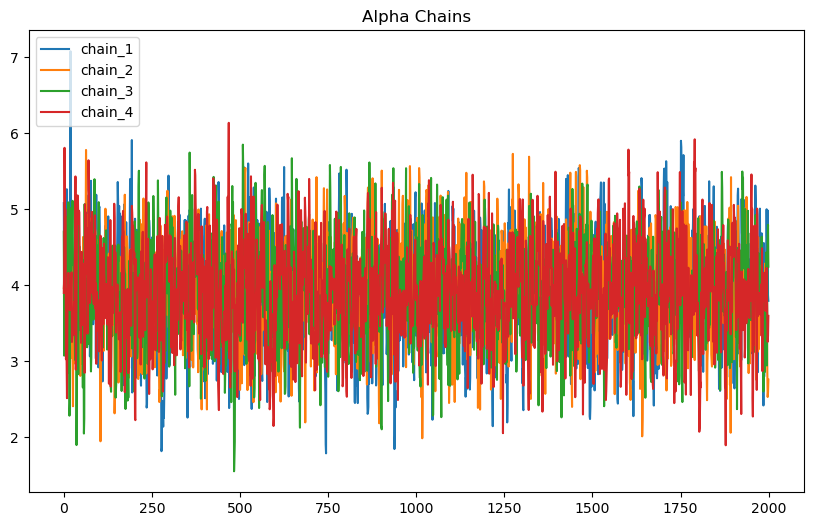

In [66]:
# Plotting chains: Checking that Alpha is Well Mixed
plt.figure(figsize=(10, 6))
for chain in ['chain_1', 'chain_2', 'chain_3', 'chain_4']:
    plt.plot(alpha_df[chain], label=chain)
plt.title("Alpha Chains")
plt.legend(loc='upper left')
plt.show()

/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/temporal_bend_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/temporal_bend_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/d/Dropbox/ORA_Training/Balikatan_2024/Python_Example_Analysis/temporal_bend_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_n

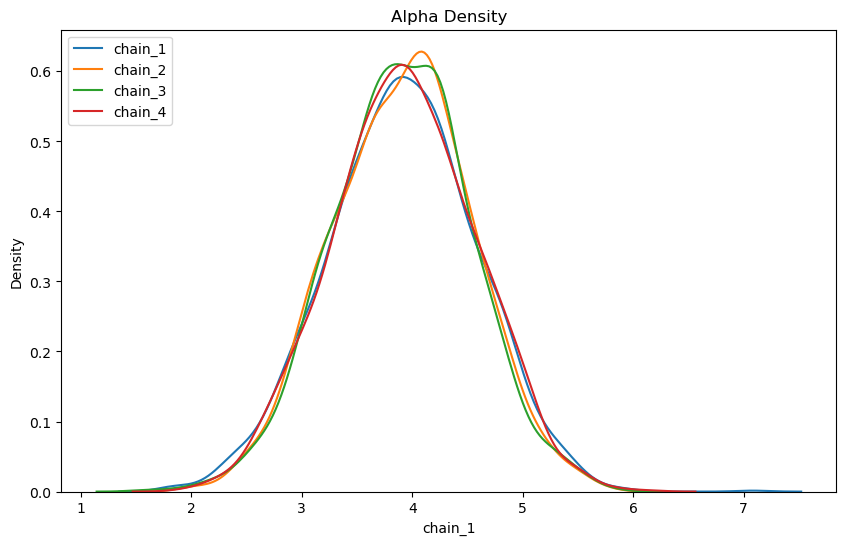

In [67]:
# Plotting density
plt.figure(figsize=(10, 6))
for chain in ['chain_1', 'chain_2', 'chain_3', 'chain_4']:
    sns.kdeplot(alpha_df[chain], label=chain)
plt.title("Alpha Density")
plt.legend(loc='upper left')
plt.show()

In [68]:
#Extract posterior predictive samples for 'y_obs'
y_rep_samples = posterior_predictive.posterior_predictive['y_obs'].values

# Reshape y_rep_samples to combine the chain and draw dimensions
y_rep_samples_reshaped = y_rep_samples.reshape(-1, y_rep_samples.shape[-1])

# Check the new shape of y_rep_samples_reshaped
print(f"y_rep_samples_reshaped shape: {y_rep_samples_reshaped.shape}")  # Should be (8000, 135)


y_rep_samples_reshaped shape: (8000, 135)


In [69]:
#Calculate posterior predictive means and standard deviations
post_means = np.mean(y_rep_samples_reshaped, axis=0)
post_stds = np.std(y_rep_samples_reshaped, axis=0)

# Ensure the shapes are correct
print(f"post_means shape: {post_means.shape}")  # Should be (135,)
print(f"post_stds shape: {post_stds.shape}")    # Should be (135,)

post_means shape: (135,)
post_stds shape: (135,)


In [70]:
#Create the targeting_predictions DataFrame
targeting_predictions = pd.DataFrame({
    'post_avg': post_means,
    'post_std': post_stds
})

#Add the outcome vector for reference
targeting_predictions['observed'] = outcome_vector

#Calculate residuals
targeting_predictions['residual'] = targeting_predictions['post_avg'] - targeting_predictions['observed']

#Display the first few rows to verify
print(targeting_predictions.head())

   post_avg  post_std  observed  residual
0  6.527002  0.830655  5.913510  0.613491
1  6.997769  0.830871  7.231288 -0.233519
2  7.312843  0.817917  7.302497  0.010346
3  7.414458  0.827473  7.231288  0.183170
4  6.504865  0.824882  5.976357  0.528507


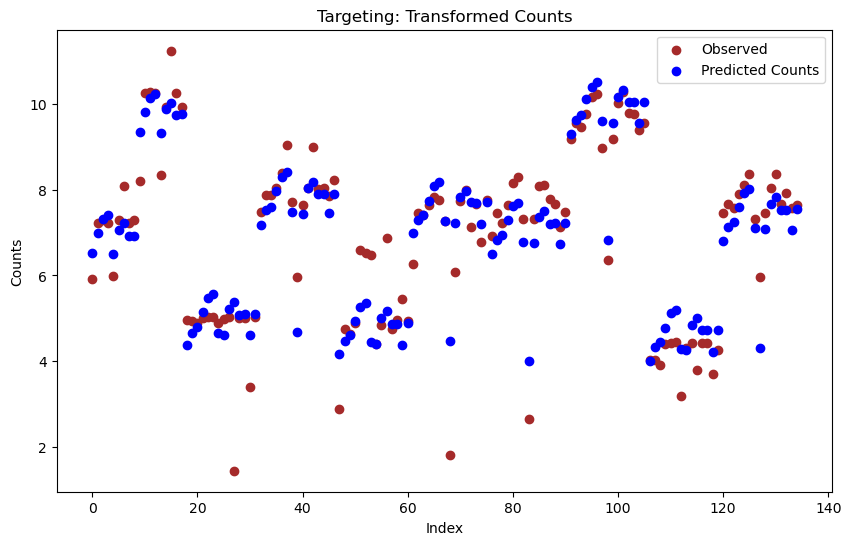

In [71]:
#Plotting the posterior predictive checks
plt.figure(figsize=(10, 6))
plt.scatter(range(len(post_means)), y, label="Observed", color="brown", marker='o')
plt.scatter(range(len(post_means)), targeting_predictions['post_avg'], label="Predicted Counts", color="blue", marker='o')
plt.title("Targeting: Transformed Counts")
plt.legend(loc='upper right')
plt.xlabel('Index')
plt.ylabel('Counts')
plt.show()

Residuals range: -3.927119585128314 to 2.038392204862446


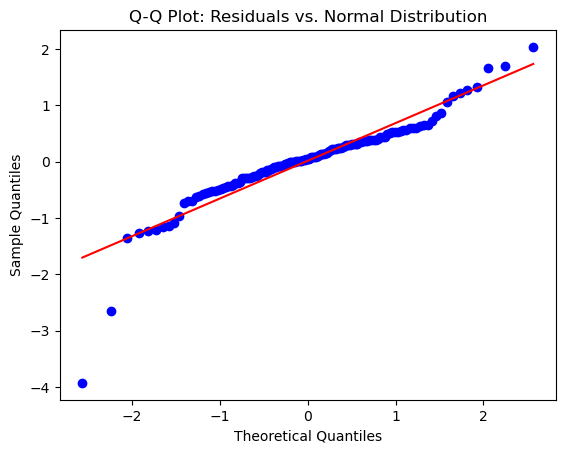

In [72]:
#Step 1: Calculate the residuals
residuals = outcome_vector - post_means

#Step 2: Check for extreme values
print(f"Residuals range: {residuals.min()} to {residuals.max()}")

# Step 3: Generate the Q-Q plot
fig, ax = plt.subplots()
stats.probplot(residuals, dist="norm", plot=ax)
ax.get_lines()[1].set_color('red')
ax.set_title('Q-Q Plot: Residuals vs. Normal Distribution')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles')
plt.show()

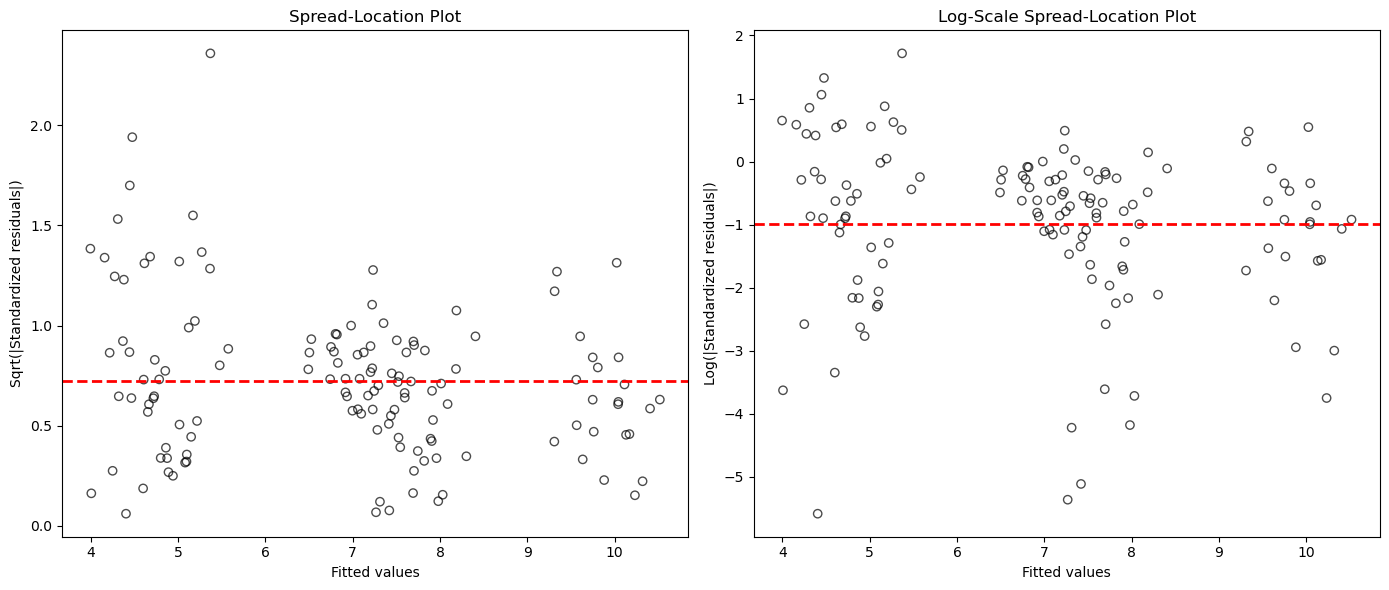

In [73]:
#Standardize residuals
standardized_residuals = residuals / np.std(residuals)

#Square root of the absolute value of standardized residuals
sqrt_abs_residuals = np.sqrt(np.abs(standardized_residuals))

#Log of the absolute residuals
log_abs_residuals = np.log(np.abs(standardized_residuals))

#Create the plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

#Panel 1: Spread-Location Plot (Sqrt(|Standardized residuals|) vs Fitted values)
axs[0].scatter(post_means, sqrt_abs_residuals, edgecolors='k', facecolors='none', alpha=0.7)
axs[0].axhline(y=np.mean(sqrt_abs_residuals), color='red', linestyle='--', linewidth=2)
axs[0].set_xlabel('Fitted values')
axs[0].set_ylabel('Sqrt(|Standardized residuals|)')
axs[0].set_title('Spread-Location Plot')

#Panel 2: Log(|Standardized residuals|) vs Fitted values
axs[1].scatter(post_means, log_abs_residuals, edgecolors='k', facecolors='none', alpha=0.7)
axs[1].axhline(y=np.mean(log_abs_residuals), color='red', linestyle='--', linewidth=2)
axs[1].set_xlabel('Fitted values')
axs[1].set_ylabel('Log(|Standardized residuals|)')
axs[1].set_title('Log-Scale Spread-Location Plot')

plt.tight_layout()
plt.show()

##### The decreased monotonic spread suggests that the model faces greater challenges in accurately fitting rarer maneuvers like Neutralize compared to more common maneuvers such as Explain.

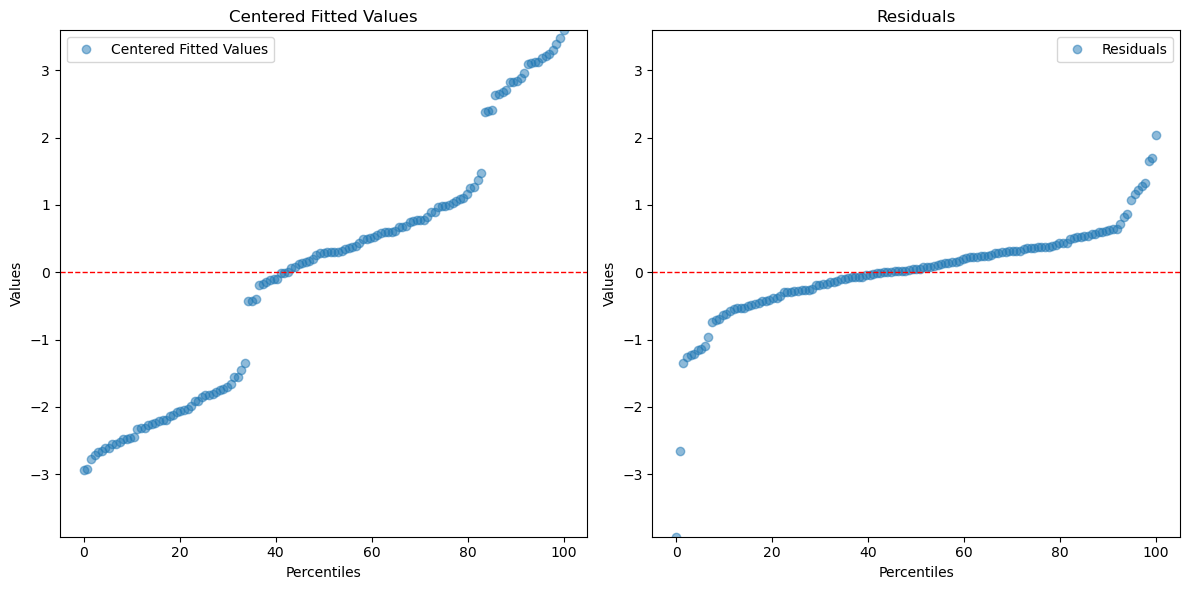

In [74]:
# Calculate centered fitted values
centered_fitted_values = post_means - np.mean(post_means)

# Compute quantiles
quantiles = np.linspace(0, 100, len(post_means))
centered_fitted_quantiles = np.percentile(centered_fitted_values, quantiles)
residual_quantiles = np.percentile(residuals, quantiles)

# Plot the R-F spread plot
plt.figure(figsize=(12, 6))

# Subplot 1: Centered Fitted Values Quantiles
plt.subplot(1, 2, 1)
plt.plot(quantiles, centered_fitted_quantiles, 'o', alpha=0.5, label='Centered Fitted Values')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Centered Fitted Values')
plt.xlabel('Percentiles')
plt.ylabel('Values')
plt.ylim(min(min(centered_fitted_quantiles), min(residual_quantiles)), 
         max(max(centered_fitted_quantiles), max(residual_quantiles)))
plt.legend()

# Subplot 2: Residuals Quantiles
plt.subplot(1, 2, 2)
plt.plot(quantiles, residual_quantiles, 'o', alpha=0.5, label='Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals')
plt.xlabel('Percentiles')
plt.ylabel('Values')
plt.ylim(min(min(centered_fitted_quantiles), min(residual_quantiles)), 
         max(max(centered_fitted_quantiles), max(residual_quantiles)))
plt.legend()

plt.tight_layout()
plt.show()

##### The negative tail of the residuals in the residuals panel of the R-F plot further indicates that the model struggles to accurately predict the count of rarer maneuvers.

##### This simple model does not account for all variations in the transformed counts, primarily due to its lack of mechanisms for addressing exogenous events such as Chinese harassment during the exercise, the alleged presence of a Chinese operatives' school, or the specific communication strategies of stance groups that make certain maneuvers rare. Nevertheless, the Q/Q, S-L, and R-F plots indicate that it functions well as a baseline model for identifying significant discrepancies, providing insights into the communication strategies of the stance groups—our primary objective.

##### Replicating these steps to model Maneuvered-Upon or Targeted counts shows that the model captures consistent targeting behavior, especially within command structures.

##### The generated model objects include all necessary information for replicating the plots found in the Example Plots directory of the repository. This example of BEND residual analysis for a temporal dataset demonstrates transitioning from ORA outputs to model predictions.

##### I used Bayesian models to capitalize on their ability to integrate domain-specific knowledge that might not be fully represented in the data, aiding in effectively quantifying uncertainties. Alternatively, this method could be adapted to a Random Effects model using statsmodels. Significant weekly variation necessitated using a Hierarchical Linear Model (HLM) for this analysis, whereas a simple linear model was adequate for Balikatan 2022.
